In [1]:
from get_data import *

/Users/zihaoxu/ENTER/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.2.4-tf
2.0.0


# Inspect Data Quality

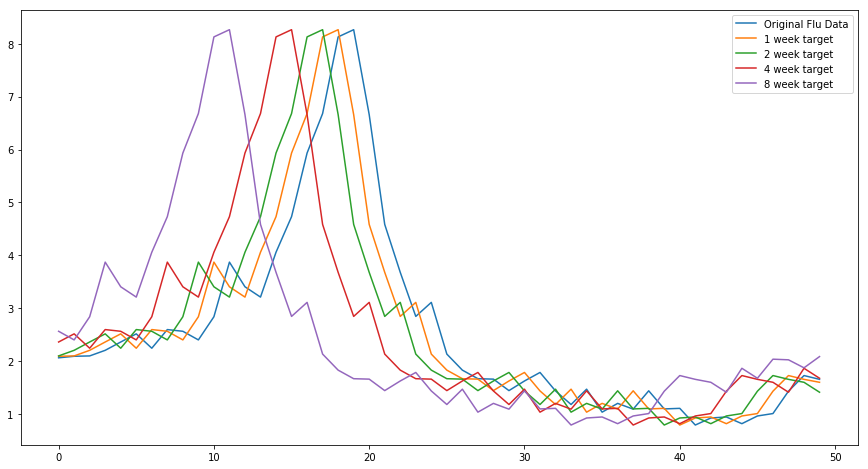

In [2]:
state = 'Texas'

orig = train_dfs[state]['texas_flu']
target_1 = train_dfs[state]['target_1']
target_2 = train_dfs[state]['target_2']
target_4 = train_dfs[state]['target_4']
target_8 = train_dfs[state]['target_8']

print_len = 50
plt.figure(figsize=(15,8))
plt.plot(orig[:print_len], label = "Original Flu Data")
plt.plot(target_1[:print_len], label = '1 week target')
plt.plot(target_2[:print_len], label = '2 week target')
plt.plot(target_4[:print_len], label = '4 week target')
plt.plot(target_8[:print_len], label = '8 week target')
plt.legend()

# Test Data Getter

In [3]:
# Get TS data
X_train, X_test, X_all, y_train, y_test, y_all = get_data(state, ['TS'], 1, None)
print(X_train.shape, X_test.shape, X_all.shape)
print(y_train.shape, y_test.shape, y_all.shape)

(368, 1) (85, 1) (453, 1)
(368, 1) (85, 1) (453, 1)


In [4]:
# Get TS with lag data
X_train, X_test, X_all, y_train, y_test, y_all = get_data(state, ['TS', 'lag_8'], 1, None)
print(X_train.shape, X_test.shape, X_all.shape)
print(y_train.shape, y_test.shape, y_all.shape)

(368, 2) (85, 2) (453, 2)
(368, 1) (85, 1) (453, 1)


In [5]:
# Get TS + GT
X_train, X_test, X_all, y_train, y_test, y_all = get_data(state, ['TS', 'GT'], 1, None)
print(X_train.shape, X_test.shape, X_all.shape)
print(y_train.shape, y_test.shape, y_all.shape)

(368, 97) (85, 97) (453, 97)
(368, 1) (85, 1) (453, 1)


In [6]:
# Get TS + other state
X_train, X_test, X_all, y_train, y_test, y_all = get_data(state, ['TS', 'other_states'], 1, None)
print(X_train.shape, X_test.shape, X_all.shape)
print(y_train.shape, y_test.shape, y_all.shape)

(368, 50) (85, 50) (453, 50)
(368, 1) (85, 1) (453, 1)


# Try out Time Series Models

### Persistence

In [7]:
def persistence(state, target_lag, if_plot=True):
    X_train, X_test, X_all, y_train, y_test, y_all = get_data(state, ['TS'], target_lag, None)
    
    # model and predict
    y_pred = inverse_transform_preds(y_train, X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"MSE for the persistence model of {state} is {mse:.6f}")
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test, label='true')
        plt.plot(y_pred, label='predicted')
        plt.legend()
        plt.show()
    
    return mse

MSE for the persistence model of Texas is 1.048463


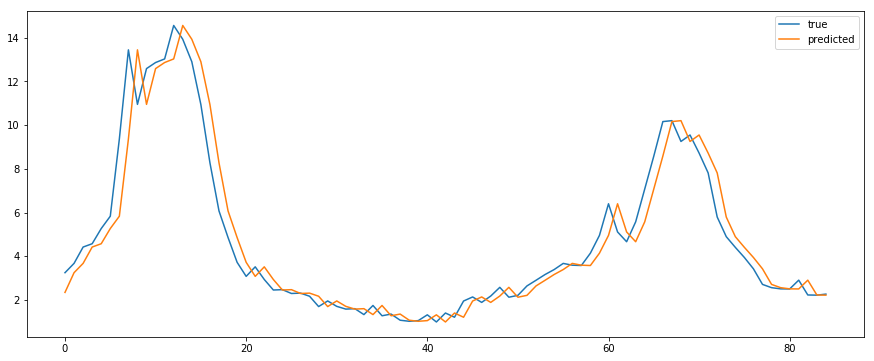

MSE for the persistence model of New York is 0.460775


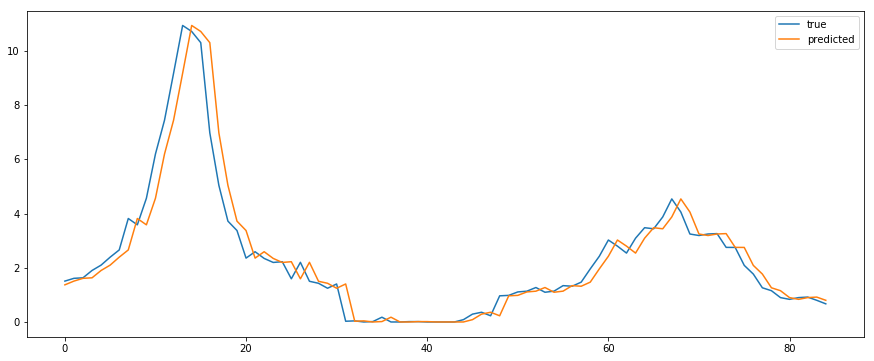

0.4607751176033856

In [8]:
persistence('Texas', 1, True)
persistence('New York', 1, True)

# AR

In [26]:
def AutoReg(target_state, ar_lag, target_lag, if_plot=True, regularizer = None):
    lag_cols = ['lag_'+str(i) for i in range(1,ar_lag)]
    X_train, X_test, X_all, y_train, y_test, y_all = get_data(target_state, ['TS']+lag_cols, target_lag)    
    
    # model and predict
    if regularizer == None:
        AR = LinearRegression().fit(X_train, y_train)
    elif regularizer == 'l1':
        AR = LassoCV(alphas=[1e-4,1e-3,1e-2,1e-1,1,2], max_iter=1e6, cv=5, random_state=109).fit(X_train, y_train.flatten())
    elif regularizer == 'l2':
        AR = RidgeCV(alphas=[1e-3,1e-2,1e-1,1,2], cv=5).fit(X_train, y_train.flatten())
    y_pred = AR.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"MSE for the AutoReg Model of {state} is {mse:.6f}")
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test, label='true')
        plt.plot(y_pred, label='predicted')
        plt.legend()
        plt.show()
    
    return mse

In [38]:
# Normal AR
AutoReg('Texas', ar_lag=26, target_lag=1, if_plot=False)
AutoReg('New York', ar_lag=26, target_lag=1, if_plot=False)

MSE for the AutoReg Model of Texas is 0.953889
MSE for the AutoReg Model of Texas is 0.411098


0.411098366829236

In [39]:
# L1 Regularization 
AutoReg('Texas', ar_lag=26, target_lag=1, if_plot=False, regularizer='l1')
AutoReg('New York', ar_lag=26, target_lag=1, if_plot=False, regularizer='l1')

MSE for the AutoReg Model of Texas is 1.045157
MSE for the AutoReg Model of Texas is 0.475232


0.4752324587434322

In [40]:
# L2 Regularization 
AutoReg('Texas', ar_lag=26, target_lag=1, if_plot=False, regularizer='l2')
AutoReg('New York', ar_lag=26, target_lag=1, if_plot=False, regularizer='l2')

MSE for the AutoReg Model of Texas is 0.987274
MSE for the AutoReg Model of Texas is 0.436802


0.43680180428593507

# ARIMA

In [ ]:
def Auto_ARIMA(target_state, ar_lag, target_lag, if_plot=True, regularizer = None):
    lag_cols = ['lag_'+str(i) for i in range(1,ar_lag)]
    X_train, X_test, X_all, y_train, y_test, y_all = get_data(target_state, ['TS']+lag_cols, target_lag)    
    
    # model and predict
    if regularizer == None:
        AR = LinearRegression().fit(X_train, y_train)
    elif regularizer == 'l1':
        AR = LassoCV(alphas=[1e-4,1e-3,1e-2,1e-1,1,2], max_iter=1e6, cv=5, random_state=109).fit(X_train, y_train.flatten())
    elif regularizer == 'l2':
        AR = RidgeCV(alphas=[1e-3,1e-2,1e-1,1,2], cv=5).fit(X_train, y_train.flatten())
    y_pred = AR.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"MSE for the AutoReg Model of {state} is {mse:.6f}")
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test, label='true')
        plt.plot(y_pred, label='predicted')
        plt.legend()
        plt.show()
    
    return mse

## LNAR

In [22]:
def lnar(target_state, predictor_state, target_lag, with_gt=False, if_plot=True):
    # get train test X y
    lag_cols = ['lag_'+str(i) for i in range(1,52)]
    X_train, X_test, X_all, y_train, y_test, y_all = get_data(target_state, ['TS']+lag_cols, target_lag, predictor_state_list=predictor_state)

    lasso = Lasso(max_iter=1e6)
    parameters = {'alpha':[1e-3, 1e-2, 1e-1, 1,5]}
    model = GridSearchCV(lasso, parameters, cv=5).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test, label='true')
        plt.plot(y_pred, label='predicted')
        plt.legend()
        plt.show() 
    print(f"RMSE for the lnar model of {target_state} is {rmse:.6f}")
    return rmse

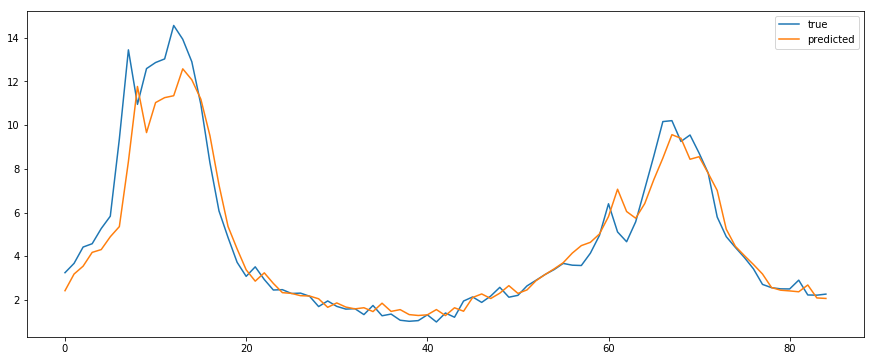

RMSE for the lnar model of Texas is 1.070510


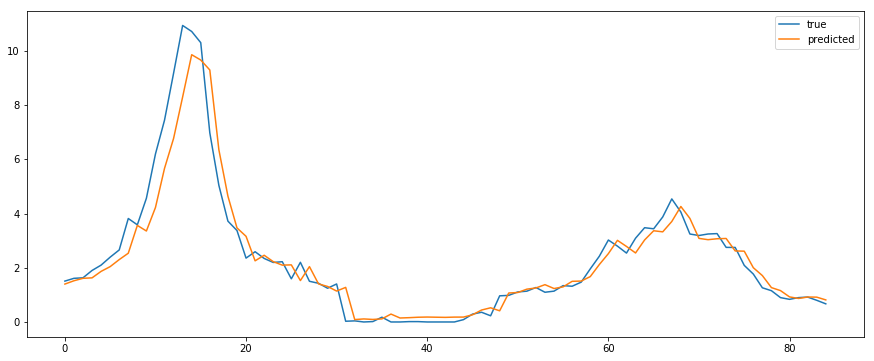

RMSE for the lnar model of New York is 0.685738


0.6857377212775968

In [23]:
lnar('Texas', ['New Mexico', 'Oklahoma', 'Louisiana', 'Arkansas'], 1, with_gt=False, if_plot=True)
lnar('New York', ['Pennsylvania', 'New Jersey', 'Connecticut', 'Massachusetts', 'Vermont'], 1, with_gt=False, if_plot=True)

In [ ]:
def walk_forward_lnar(target_state, predictor_state, future_week, with_gt=False, if_plot=True, refit_period=12):
    
    def lasso_refit(X, y):
        lasso = Lasso(max_iter=1e6)
        parameters = {'alpha':[.1, .01, .001, .0001, .00001]}
        model = GridSearchCV(lasso, parameters, cv=5).fit(X, y)
        return model
    
    # get train test
    X_train, X_test, X_all, y_train, y_test, y_all, scaler = get_data(target_state, future_week, with_gt=with_gt, predictor_state=predictor_state)
    
    # get autoregressive terms
    for i in range(52):
        for col in predictor_state:
            X_train['{} lag {}'.format(col, i+1)] = X_train[col].shift(i+1)
            na = X_train['{} lag {}'.format(col, i+1)][X_train['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_train['{} lag {}'.format(col, i+1)] = X_train['{} lag {}'.format(col, i+1)].fillna(na)
            
            X_test['{} lag {}'.format(col, i+1)] = X_test[col].shift(i+1)
            na = X_test['{} lag {}'.format(col, i+1)][X_test['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_test['{} lag {}'.format(col, i+1)] = X_test['{} lag {}'.format(col, i+1)].fillna(na)
            
    train_len = len(X_train)
    test_len = len(X_all) - train_len 
    y_pred = np.zeros((test_len))
    

    for t in range(test_len):
        X_train_temp = X_all.values[:train_len+t]
        y_train_temp = y_all[:train_len+t]
        X_test_temp = X_all.values[train_len+t:]
        
        if t % refit_period == 0: 
            print(f"Refit at {t+1}/{test_len}.")
            lasso = lasso_refit(X_train_temp, y_train_temp)
            
        preds = lasso.predict(X_test_temp)
        reverse_preds = scaler.inverse_transform(np.array(preds).reshape(-1,1))
        y_pred[t] = reverse_preds[0]
        
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test, label='true')
        plt.plot(y_pred, label='predicted')
        plt.legend()
        plt.show() 
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE for the walk_forward_lnar model of {target_state} is {rmse:.6f}")
    return rmse

    return y_pred

In [ ]:
walk_forward_lnar('Texas', ['New Mexico', 'Oklahoma', 'Louisiana', 'Arkansas'], 1, if_plot=True)
walk_forward_lnar('New York', ['Pennsylvania', 'New Jersey', 'Connecticut', 'Massachusetts', 'Vermont'], 1,  if_plot=True)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg



In [ ]:
# Autoreg
y_pred = walk_forward_ts(X_train_ts, X_all_ts, lags=52, model_name = 'ar')
plot_predictions(y_train, y_test, 'AR', y_pred)

### Random Forest

In [ ]:
param_grid = {'n_estimators' : [200, 300],
              'max_depth' : [5, 10, 20]}
tscv = TimeSeriesSplit(n_splits=5)

rf = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=tscv, n_jobs=2, verbose=1).fit(X_train_states, y_train)
y_pred = rf.predict(X_test_states)

rf_gt = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=tscv, n_jobs=2, verbose=1).fit(X_train_gt, y_train)
y_pred_gt = rf_gt.predict(X_test_gt)

plot_predictions(y_train, y_test, 'rf', y_pred, 'rf_gt', y_pred_gt)

In [ ]:
importances = rf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

print("Most important features rf:")
print(np.array(state_columns+[flu_colname])[indices][:20])

importances = rf_gt.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

print("Most important features rf:")
np.array(gt_columns+[flu_colname])[indices][:20]

### XGBoost

In [ ]:
import xgboost as xgb

param_grid = {'alpha': [1e-2, 1],
              'max_depth' : [5, 7, 9],
              'min_child_weight': [3, 5, 7],
              'gamma': [1e-2, 1],
              'subsample': [0.8, 0.9, 1.0],
              'colsample_bytree': [0.8, 0.9, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)

model = xgb.XGBRegressor(learning_rate = 0.01, n_estimators= 1000, early_stopping_rounds = 50)

xgb_b = RandomizedSearchCV(model, 
                         param_distributions=param_grid, 
                         cv=tscv, 
                         n_jobs=2,
                         n_iter=20,
                         scoring='neg_mean_squared_error',
                         verbose=1,
                         random_state=47
                        ).fit(X_train_states, y_train)
y_pred = xgb_b.predict(X_test_states)

xgb_gt = RandomizedSearchCV(model, 
                         param_distributions=param_grid, 
                         cv=tscv, 
                         n_jobs=2,
                         n_iter=20,
                         scoring='neg_mean_squared_error',
                         verbose=1,
                         random_state=47
                        ).fit(X_train_gt, y_train)
y_pred_gt = xgb_gt.predict(X_test_gt)

In [ ]:
plot_predictions(y_train, y_test, 'xgb', y_pred, 'xgb_gt', y_pred_gt)

In [ ]:

# dtrain = xgb.DMatrix(df_state_train[X_train_predictors], y_train)
# dvalid = xgb.DMatrix(df_state_test[X_train_predictors], y_test)
# dtrain_gt = xgb.DMatrix(pd.concat((df_state_train[X_train_predictors], df_state_gt_train),axis=1), y_train)
# dvalid_gt = xgb.DMatrix(pd.concat((df_state_test[X_train_predictors], df_state_gt_test),axis=1), y_test)

# watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# watchlist_gt = [(dtrain_gt, 'train'), (dvalid_gt, 'valid')]

# params = xgb_gt.best_estimator_.get_xgb_params()

# model = xgb.train(params = params, 
#                   dtrain = dtrain_gt, 
#                   num_boost_round = 1000, 
#                   evals = watchlist_gt, 
#                   early_stopping_rounds = 50, 
#                   verbose_eval = 50)

In [ ]:
# from xgboost import plot_importance

# fg,ax = plt.subplots(1,1,figsize=(12,20))
# plot_importance(model, ax=ax)

### Vanilla NN

In [ ]:
def create_NN(X,y,batch_size,epochs,verbose):
    tf.random.set_seed(4747)
    np.random.seed(4747)
    n_units = 64
    drop_rate = .2
    optimizer = RMSprop(1e-4)
    loss = "mse"
    batch_size = batch_size
    epochs = epochs
    validation_split = 0.2
    verbose = verbose
    
    model = tf.keras.Sequential()
    model.add(Dense(input_dim=(X.shape[1]),units = n_units,activation = 'relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(units = n_units,activation = 'relu'))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer=optimizer, loss=loss)
    es = EarlyStopping(patience=10)
    model.fit(X,y,
              batch_size=batch_size, epochs=epochs, 
              validation_split=validation_split,
              verbose=verbose, callbacks=[es])
    return model

In [ ]:
nn = create_NN(X_train_states, y_train,32,100,0)
y_pred = nn.predict(X_test_states)
nn_gt = create_NN(X_train_gt, y_train,32,100,0)
y_pred_gt = nn_gt.predict(X_test_gt)

plot_predictions(y_train, y_test, 'nn', y_pred, 'nn_gt', y_pred_gt)

In [ ]:
# def walk_forward_prediction(model_fn, X_all, X_train, y_all):
#     size = len(X_train)
#     max_train_size = size
#     y_pred = []
#     test_len = len(y_test)

#     for t in range(test_len):
#         if t%(test_len//10) == 0: print(f"Finished {t}/{test_len}")
#         X_train_temp, X_test_temp = X_all[size+t-max_train_size:size+t], X_all[size+t:]
#         y_train_temp = y_all[size+t-max_train_size:size+t]
#         model = model_fn(X_train_temp, y_train_temp,32,100,0)
#         pred = model.predict(X_test_temp)
#         y_pred.append(pred[0])
#     return y_pred

# nn_fw_pred = walk_forward_prediction(create_NN, X_all, X_train, y_all)
# nn_fw_pred_gt = walk_forward_prediction(create_NN, X_all_gt, X_train_gt, y_all)
# plot_predictions(y_train, y_test, 'nn_fw',  nn_fw_pred, 'nn_fw_gt',  nn_fw_pred_gt)

In [ ]:
# optimizer = "rmsprop"
# loss = "mae"

# n_steps, n_features = X_train.shape[0], X_train.shape[1]
# n_units = 64
# batch_size = 32
# epochs = 10
# validation_split = 0.2
# verbose = 1

# model = Sequential()
# model.add(SimpleRNN(n_units, activation='relu', input_shape=(n_steps, n_features)))
# model.add(Dense(1, activation='relu'))
          
# # Compile model
# model.compile(optimizer=optimizer, loss=loss)
# print(model.summary())

# # Train model
# history = model.fit(X_train.reshape(1,X_train.shape[0],X_train.shape[1]),
#                     y_train.reshape(1,y_train.shape[0]),
#                     batch_size=batch_size, epochs=epochs, 
#                     validation_split=validation_split, verbose=verbose)